In [1]:
# Install necessary requirements
# !pip install -r requirements


In [36]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import os
import random
import numpy as np
import cv2
import joblib
import helper_module
import itertools
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet50, VGG19, MobileNetV3Large, EfficientNetV2S, DenseNet121, ResNet50V2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models, layers, Model
from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split


Check if TPU is available

In [3]:
# Check if a TPU is available
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("TPU detected and initialized.")
except ValueError:
    # No TPU found, specify GPU or CPU here
    use_gpu = True  # Set this to True to use GPU or False to use CPU
    if use_gpu and tf.config.list_physical_devices("GPU"):
        strategy = tf.distribute.MirroredStrategy()  # Use GPU
        print("Using GPU for TensorFlow computations.")
    else:
        strategy = tf.distribute.get_strategy()  # Use CPU
        print("Using CPU for TensorFlow computations.")

# Now you can define and run your TensorFlow model using the selected strategy

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


2023-09-27 23:41:44.413075: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x562e33d30d80 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
2023-09-27 23:41:44.413117: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): TPU, 2a886c8
2023-09-27 23:41:44.413128: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): TPU, 2a886c8
2023-09-27 23:41:44.413138: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): TPU, 2a886c8
2023-09-27 23:41:44.413148: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (3): TPU, 2a886c8
2023-09-27 23:41:44.413158: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (4): TPU, 2a886c8
2023-09-27 23:41:44.413168: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (5): TPU, 2a886c8
2023-09-27 23:41:44.413177: I tensorflow/compiler/xla/service/service.cc:176]   StreamEx

INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

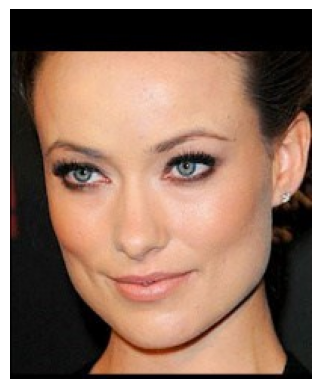

In [4]:
helper_module.show_img('dataset/train/left/abn.jpg')
train_pairing_df =helper_module.read_csv_to_df('dataset/train.csv')
test_candidates_df = helper_module.read_csv_to_df('dataset/test_candidates.csv')
archive_images_df = helper_module.read_csv_to_df('archive/votes.csv')

1.  Create two data generator
    1.  Dissimilar_datagen to generate data thats not gonna be in the similar pair
    2.  Similar_datagen to generate data thats going tobe in the similar pair

-   The major difference between is for similar  ones, the only thing that can be augmented will be width and heigh shift range. But for dissimilar, it can be more diversed, thats because for similar images, any other augmentations can effect the quality of the similar pair.

In [5]:
dissimilar_datagen = ImageDataGenerator(
    rescale=1./255,         # Rescale pixel values to [0, 1]
    rotation_range=0.2,      # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # Randomly shift image width by up to 20%
    height_shift_range=0.2, # Randomly shift image height by up to 20%
    shear_range=0.2,        # Shear transformations
    zoom_range=0.2,         # Randomly zoom in on images by up to 20%
    horizontal_flip =True,   # Randomly flip images horizontally
    vertical_flip = True,
    fill_mode='nearest'     # Fill mode for newly created pixels
)


similar_datagen = ImageDataGenerator(
    rescale=1./255,         # Rescale pixel values to [0, 1]
    rotation_range=0.0,      # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # Randomly shift image width by up to 20%
    height_shift_range=0.2, # Randomly shift image height by up to 20%
    shear_range=0.0,        # Shear transformations
    zoom_range=0.0,         # Randomly zoom in on images by up to 20%
    horizontal_flip = False,   # Randomly flip images horizontally
    vertical_flip = False,
    fill_mode='nearest'     # Fill mode for newly created pixels
)

Now Pair up the left and right image
1. The Data format will be  [Left,Right] this will be a pair of similar image
2. The load_and_preprocess_image takes in the image_path, and load and preproceess image with specifc data generator based on randon_transform.
3. The create_train_valid_pair takes in the Boolean value and create dataset of valid pairs of similar images.
4. The create_train_valid_pair_archive does the same but with external dataset


In [6]:
def load_and_preprocess_image(image_path,  datagen = None, target_size=(224,224), random_transform=False):
    # Open the image using Pillow (PIL)
    img = load_img(image_path, target_size=target_size)

    img = img.resize(target_size)

    img = img_to_array(img, dtype='uint8')


    if random_transform:
        img = datagen.random_transform(img)

    return img

def create_train_valid_pair(random_transform):
    # Create a list to store the dataset
    dataset = []

    # Iterate through the rows of the CSV file and load/preprocess the images
    for index, row in train_pairing_df.iterrows():
        left_image = load_and_preprocess_image(f"dataset/train/left/{row['left']}.jpg", similar_datagen, random_transform=random_transform)

        # Load and preprocess similar image
        similar_image = load_and_preprocess_image(f"dataset/train/right/{row['right']}.jpg", similar_datagen, random_transform=random_transform)

        # Create a data entry containing the left image, list of right images, and the index of the similar image
        data_entry = [left_image, similar_image]
        dataset.append(data_entry)

    return dataset

def create_train_valid_pair_archive(random_transform):
    # Create lists to store paired left and right images
    image_pairs_with_label = []

    # Define the directory path where your images are located
    left_image_directory = 'archive/left/left/'  # Update with the correct directory path
    right_image_directory = 'archive/right/right/'  # Update with the correct directory path

    # Define the range for generating random indices
    min_idx = 1
    max_idx = 6015

    # Iterate through the rows of the CSV file and load/preprocess the images
    for index, row in archive_images_df.iterrows():
        # Generate the filename based on the index (e.g., '00000.jpg', '00001.jpg', etc.)
        image_filename = f"{index + 1:05d}.jpg"

        # Construct the full paths to the left and right images
        left_image_path = os.path.join(left_image_directory, image_filename)
        right_image_path = os.path.join(right_image_directory, image_filename)

        # Check if both image files exist
        if os.path.exists(left_image_path) and os.path.exists(right_image_path) and row['wins']>row['fails']:
            # Load and preprocess the left image
            left_image = load_and_preprocess_image(left_image_path, similar_datagen, random_transform=random_transform)

            # Load and preprocess the right image
            right_image = load_and_preprocess_image(right_image_path, similar_datagen, random_transform=random_transform)

            # Create a pair with left image and a list of right images
            image_pair_with_label = [left_image, right_image]

            image_pairs_with_label.append(image_pair_with_label)
        else:
            print(f"Not similar {index + 1}: {left_image_path}, {right_image_path}")


    return image_pairs_with_label


Pair up images with similar images and try to save them in the current working directory so it can be resued later even after restart of the kernel

In [7]:
def display_image_pair(image_pair):
    plt.figure(figsize=(8, 4))
    
    # Display the left image
    plt.subplot(1, 2, 1)
    plt.imshow(image_pair[0])
    plt.title('Left Image')
    plt.axis('off')
    
    # Display the right image
    plt.subplot(1, 2, 2)
    plt.imshow(image_pair[1])
    plt.title('Right Image')
    plt.axis('off')
    
    plt.show()

def create_and_save_combined_dataset():
    train_valid_offical_pair_dataset = create_train_valid_pair(False)
    train_valid_outside_pair_dataset = create_train_valid_pair_archive(False)
    # Save data
    joblib.dump(train_valid_offical_pair_dataset, 'train_valid_offical_pair_dataset.joblib')
    joblib.dump(train_valid_outside_pair_dataset, 'train_valid_outside_pair_dataset.joblib')
    

In [8]:
# Try to load the dataset
try:
    train_valid_offical_pair_dataset = joblib.load('train_valid_offical_pair_dataset.joblib')
    train_valid_outside_pair_dataset = joblib.load('train_valid_outside_pair_dataset.joblib')
    
    train_valid_dataset = train_valid_offical_pair_dataset + train_valid_outside_pair_dataset

    print(f"Loaded train_valid_offical_pair_dataset size is {len(train_valid_offical_pair_dataset)}")
    print(f"Loaded train_valid_outside_pair_dataset size is {len(train_valid_outside_pair_dataset)}")
except FileNotFoundError:
    print("Dataset not found, creating and saving...")
    create_and_save_combined_dataset()
    train_valid_offical_pair_dataset = joblib.load('train_valid_offical_pair_dataset.joblib')
    train_valid_outside_pair_dataset = joblib.load('train_valid_outside_pair_dataset.joblib')
    train_valid_dataset = train_valid_offical_pair_dataset + train_valid_outside_pair_dataset
    print(f"Created and saved train_valid_offical_pair_dataset size is {len(train_valid_offical_pair_dataset)}")
    print(f"Created and saved train_valid_outside_pair_dataset size is {len(train_valid_outside_pair_dataset)}")


Loaded train_valid_offical_pair_dataset size is 2000
Loaded train_valid_outside_pair_dataset size is 5445


To display image pairs and also showing some matched features

2


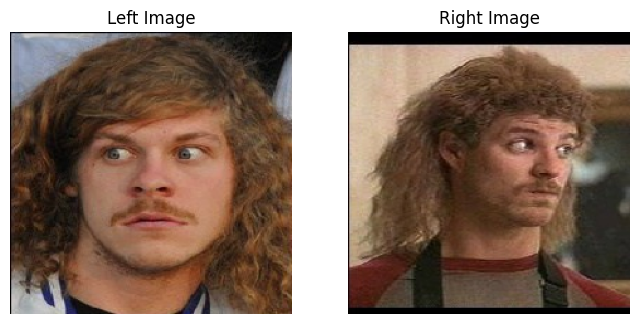

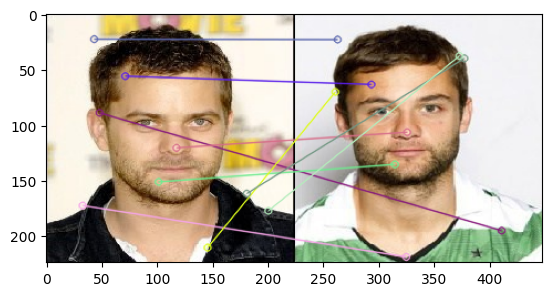

In [9]:
# Now you have the dataset loaded or created, and you can work with it as needed.
print(len(train_valid_dataset[6000]))
display_image_pair(train_valid_dataset[6000])

orb = cv2.ORB_create()
sift = cv2.SIFT_create()

# show_local_features(sift,train_valid_dataset[5][0][0])
helper_module.draw_image_matches(sift, train_valid_dataset[5000])

We also need to combine all images together into a dataset in order to select randomly in this pool

In [10]:
def load_images_from_folder(folder_path, datagen):
    image_list = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Add more conditions for other image formats
            img = load_and_preprocess_image(os.path.join(folder_path, filename), datagen=datagen, random_transform=True)
            image_list.append(img)
    return np.array(image_list)

official_right_folder_path = "dataset/train/right"
official_left_folder_path = "dataset/train/left"

outside_right_folder_path = "archive/right/right"
outside_left_folder_path = "archive/left/left"

try:
    official_right_images = joblib.load('official_right_images.joblib')
    official_left_images = joblib.load('official_left_images.joblib')
    outside_right_images = joblib.load('outside_right_images.joblib')
    outside_left_images = joblib.load('outside_left_images.joblib')
    
except FileNotFoundError:

    official_right_images = load_images_from_folder(official_right_folder_path,dissimilar_datagen)
    official_left_images = load_images_from_folder(official_left_folder_path,dissimilar_datagen)
    outside_right_images = load_images_from_folder(outside_right_folder_path,dissimilar_datagen)
    outside_left_images = load_images_from_folder (outside_left_folder_path,dissimilar_datagen)

    # Save to disk
    joblib.dump(official_right_images, 'official_right_images.joblib')
    joblib.dump(official_left_images, 'official_left_images.joblib')
    joblib.dump(outside_right_images, 'outside_right_images.joblib')
    joblib.dump(outside_left_images, 'outside_left_images.joblib')

image_pool = np.concatenate([official_right_images, official_left_images, outside_right_images, outside_left_images])

print(f"there are {len(image_pool)} images in image pool each with shape {image_pool[0].shape}")

there are 16032 images in image pool each with shape (224, 224, 3)


Functions for pick random images from pool 

In [11]:
def pick_random_images(image_pool, num_images):
    """
    Pick a specific number of random images from a given image pool.

    Parameters:
    - image_pool (numpy array): The array containing all the images.
    - num_images (int): The number of random images to pick.

    Returns:
    - random_images (numpy array): Array containing the random images picked.
    """

    # Make sure the image pool has enough images to pick from
    if len(image_pool) < num_images:
        raise ValueError("The image pool contains fewer images than requested.")

    # Randomly pick indices
    random_indices = np.random.choice(len(image_pool), num_images, replace=False)
    
    # Get the random images
    random_images = image_pool[random_indices]
    
    return random_images

def show_images(images, ncols=5):
    """
    Show multiple images in a grid.

    Parameters:
    - images (numpy array): The array containing all the images to show.
    - ncols (int): Number of columns in the grid.
    """

    n_images = len(images)
    n_rows = int(np.ceil(n_images / ncols))

    fig, axes = plt.subplots(nrows=n_rows, ncols=ncols, figsize=(15, 15))
    
    # Flatten the axes in case it's multi-dimensional
    axes = axes.flatten()

    for i in range(n_images):
        ax = axes[i]
        ax.imshow(images[i].astype('uint8'))
        ax.axis('off')
    
    # Hide any remaining empty subplots
    for i in range(n_images, len(axes)):
        axes[i].axis('off')

    plt.show()

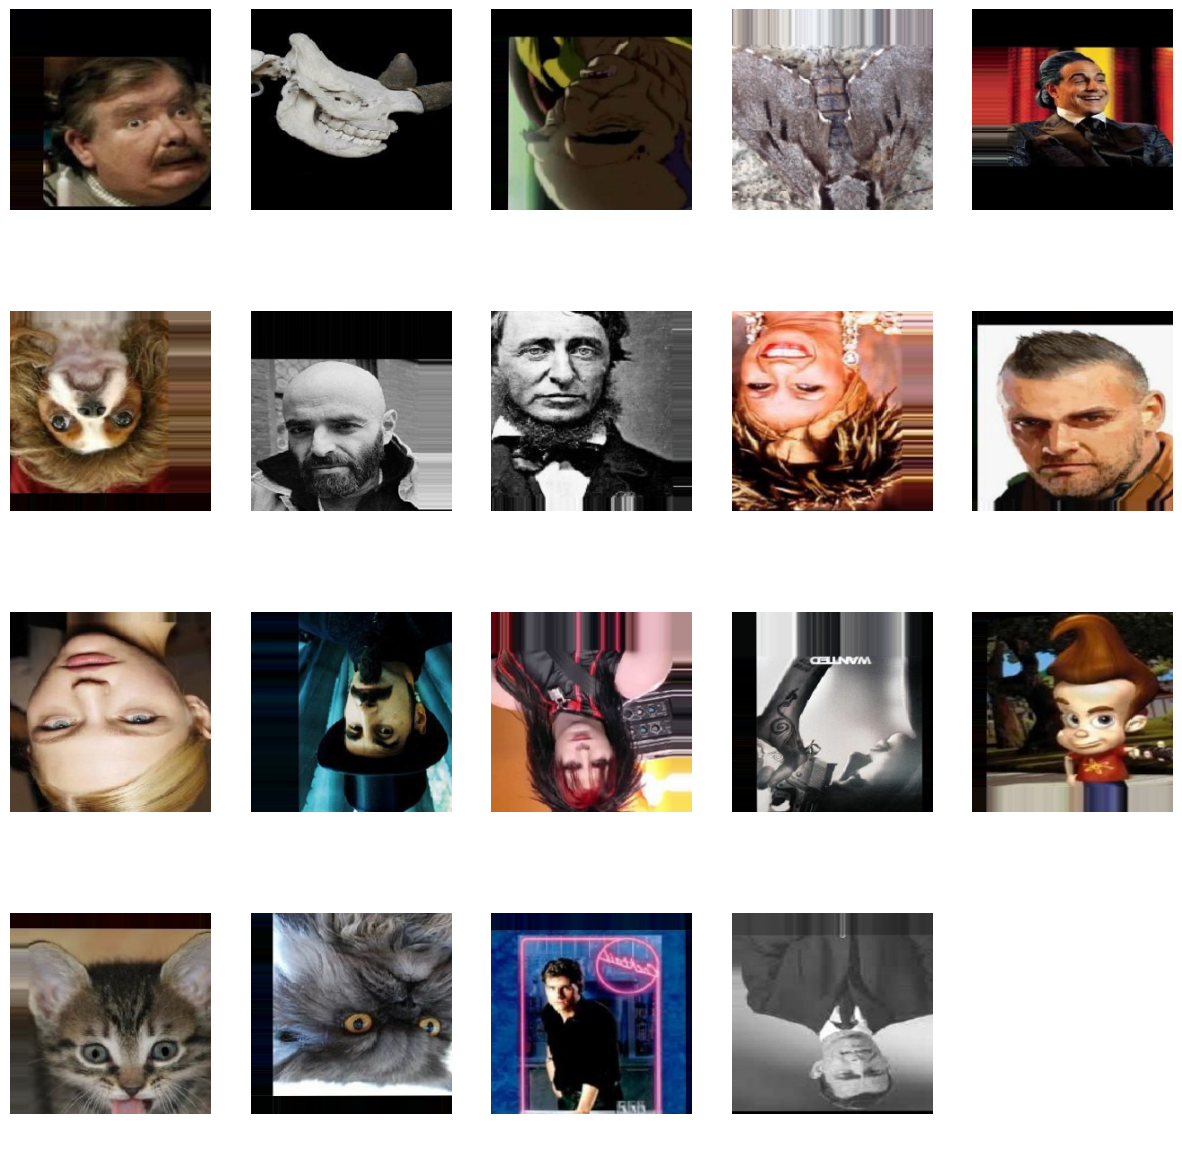

Picked 19 random images.


In [12]:
num_images_to_pick = 19  # The number of random images you want
random_images = pick_random_images(image_pool, num_images_to_pick)
# Show the random images
show_images(random_images)
print(f"Picked {len(random_images)} random images.")

Create model

In [13]:
def create_siamese_with_model(input_shape, base_model, num_right_inputs=1):
   
    input_left = tf.keras.layers.Input(shape=input_shape, name="left_input")
    input_right_list = tf.keras.layers.Input(shape=(num_right_inputs,) + input_shape, name="right_input")

    
    # Split and reshape the right input images
    split_right_inputs = Lambda(lambda x: [tf.squeeze(split, axis=1) for split in tf.split(x, num_or_size_splits=num_right_inputs, axis=1)])(input_right_list)
    
    embedding = create_embedding_model(input_shape, base_model)

    output_left = embedding(input_left)
    output_right_list = [embedding(right_input) for right_input in split_right_inputs]

    # Calculate similarity scores (cosine similarity)
    raw_similarity_scores = [layers.Dot(axes=-1, normalize=True)([output_left, right]) for right in output_right_list]
    
    # Convert raw similarity scores to [0, 1] range
    adjusted_similarity_scores = [Lambda(lambda x: (1 + x) / 2)(raw_score) for raw_score in raw_similarity_scores]

    # Concatenate similarity scores
    concatenated = layers.Concatenate(axis=1, name="similarity_scores")(adjusted_similarity_scores)

    siamese_model = models.Model(inputs=[input_left, input_right_list], outputs=concatenated)

    return siamese_model

def create_embedding_model(input_shape, base_model):
    input_image = tf.keras.layers.Input(shape=input_shape)
    features = base_model(input_image)

    flatten = layers.Flatten()(features)

    dense1 = layers.Dense(1024, activation="relu")(flatten)
    dense1 = layers.BatchNormalization()(dense1)
    dense1 = layers.Dropout(0.5)(dense1)

    output = layers.Dense(256)(dense1)  # Final embedding size of 128

    embedding = models.Model(input_image, output, name="Embedding")

    return embedding

To find out the performance of each different pretrained models

1.  The idea is to generate a set with 1 left image and 20 right images which contains one similar image. The input format will be [left,[right1,right2,right3...]The similar image will always be on index 0.

In [14]:
# Split the dataset into training and validation sets (e.g., 80% for training, 10% for validation)
train_pairs, valid_pairs = train_test_split(train_valid_dataset, test_size=0.2, random_state=42)

def generator(pair_list):
    for pair in pair_list:
        left_image, similar_image = pair[0], pair[1]
        # Get 19 random images from right_official_images
        right_images_list = [similar_image]
        random_dissimilar_images = pick_random_images(image_pool,19)
    
        right_images_array = np.concatenate([right_images_list,random_dissimilar_images])
        if right_images_array.shape == (20, 224, 224, 3):
            label = [1] + [0] * 19  # Create labels dynamically
            yield (left_image, right_images_array), label
        else:
            print(f"Skipped due to shape mismatch shape is {right_images_array.shape}")

def create_dataset(pair_list,batch_size):
    output_signature = (
        (tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(20, 224, 224, 3), dtype=tf.float32)),
        tf.TensorSpec(shape=(20,), dtype=tf.int32))
        
    return tf.data.Dataset.from_generator(
        lambda: generator(pair_list), 
        output_signature=output_signature
    ).batch(batch_size).repeat().prefetch(tf.data.experimental.AUTOTUNE)


Custom contrastive loss function

In [24]:
def custom_contrastive_loss(Y_true, D):
    margin = 1.0  # Hyperparameter, you can tune this
    true_score = D[:, 0]
    negative_scores = D[:, 1:]
    highest_negative = K.max(negative_scores, axis=1)
    loss = K.maximum(0.0, highest_negative - true_score + margin)
    return K.mean(loss)

In [33]:



with strategy.scope():
    num_epochs = 10 # Adjust the number of epochs as needed
    batch_size = 128  # Adjust the batch size as needed
    number_of_right_images = 20
    input_shape = (224,224, 3)

    # Create datasets
    train_dataset = create_dataset(train_pairs,batch_size)
    valid_dataset = create_dataset(valid_pairs,batch_size)

    # Inspect one batch from the training dataset
    for one_batch in train_dataset.take(1):
        (left_images, right_images_list), labels = one_batch
        print("Shape of left_images:", left_images.shape)
        print("Shape of right_images_list:", right_images_list.shape)
        print("Shape of labels:", labels.shape)

    try:
        siamese_model = tf.keras.models.load_model('ResNet50_before_transfer.keras',custom_objects={'custom_contrastive_loss': custom_contrastive_loss},safe_mode=False)
        siamese_model.summary()
    except Exception as e:
        print("Error during model loading:", str(e))
        VGG19_model = VGG19(
            weights="imagenet",
            input_shape=input_shape,
            include_top=False,
        )

        ResNet50_model = ResNet50(
            weights="imagenet",
            input_shape=input_shape,
            include_top=False,
        )

        MobileNetV3Large_model = MobileNetV3Large(
            weights="imagenet",
            input_shape=input_shape,
            include_top=False,
        )

        EfficientNetV2S_model = EfficientNetV2S(
            weights="imagenet",
            input_shape=input_shape,
            include_top=False,
        )


        EfficientNetV2S_model.trainable = False
        ResNet50_model.trainable = False
        MobileNetV3Large_model.trainable = False
        VGG19_model.trainable = False
        # Create the Siamese network
        siamese_model = create_siamese_with_model(input_shape,base_model= ResNet50_model,num_right_inputs=number_of_right_images)
        # Compile the model
        siamese_model.compile(loss=custom_contrastive_loss, optimizer=Adam(0.0001), metrics=[tf.keras.metrics.TopKCategoricalAccuracy(k=1)])
        siamese_model.summary()

        try:
            history = siamese_model.fit(
                x=train_dataset,
                steps_per_epoch=len(train_pairs) // batch_size,
                validation_data=valid_dataset,
                validation_steps=len(valid_pairs) // batch_size,
                epochs=num_epochs,
            )
            siamese_model.save('ResNet50_before_transfer.keras')
        except Exception as e:
            print("Error during training:", str(e))



Shape of left_images: (128, 224, 224, 3)
Shape of right_images_list: (128, 20, 224, 224, 3)
Shape of labels: (128, 20)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 right_input (InputLayer)    [(None, 20, 224, 224, 3)]    0         []                            
                                                                                                  
 left_input (InputLayer)     [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 lambda (Lambda)             [(None, 224, 224, 3),        0         ['right_input[0][0]']         
                              (None, 224, 224, 3),                                                
                              (None, 224, 224, 3),                        

In [35]:
siamese_model.evaluate(valid_dataset,batch_size=128,steps=len(valid_pairs) // batch_size)

2023-09-28 01:12:21.136292: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:784"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT32
        }
      }
    }
  }
}

2023-09-28 01:12:51.302858: I tensorflow/core/tpu/graph_rewrite/encapsulate_tpu_computations_pass.cc:238] Subgraph fingerprint:7519927356610101272


11/11 [==============================] - 49s 669ms/step - loss: 0.8904 - top_k_categorical_accuracy: 0.8651


[0.8904170989990234, 0.8650568127632141]

In [18]:
ResNet50_model_test = ResNet50(
        weights="imagenet",
        input_shape=input_shape,
        include_top=False,
    )

print(ResNet50_model_test.summary())

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_8[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

- Transfer learning
- Now we need to unfreeze some of the layers in the base model and try to get better at accuracy
- But we need to keep the learning rate very very low to keep the weights stable

In [29]:
with strategy.scope():
    # Unfreeze the last MBConv block
    # Access the 'Embedding' layer
    embedding_layer = siamese_model.get_layer('Embedding')

    # Access the base model within 'Embedding'
    base_model = embedding_layer.get_layer('resnet50') 
    for layer in base_model.layers:
        if 'conv5' in layer.name:  # unfreeze certain blocks
            layer.trainable = True
     
    siamese_model.compile(loss=custom_contrastive_loss, optimizer=Adam(0.00001), metrics=[tf.keras.metrics.TopKCategoricalAccuracy(k=1)])
    siamese_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 right_input (InputLayer)    [(None, 20, 224, 224, 3)]    0         []                            
                                                                                                  
 left_input (InputLayer)     [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 lambda (Lambda)             [(None, 224, 224, 3),        0         ['right_input[0][0]']         
                              (None, 224, 224, 3),                                                
                              (None, 224, 224, 3),                                                
                              (None, 224, 224, 3),                                            

In [30]:
num_epochs = 10
try:
    history = siamese_model.fit(
        x=train_dataset,
        steps_per_epoch=len(train_pairs) // batch_size,
        validation_data=valid_dataset,
        validation_steps=len(valid_pairs) // batch_size,
        epochs=num_epochs,
    )
except Exception as e:
    print("Error during training:", str(e))

2023-09-28 00:35:54.432015: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:392"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT32
        }
      }
    }
  }
}



Epoch 1/10


2023-09-28 00:38:22.183108: I tensorflow/core/tpu/graph_rewrite/encapsulate_tpu_computations_pass.cc:238] Subgraph fingerprint:1605611252913757915
2023-09-28 00:38:35.057559: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.
2023-09-28 00:38:39.511873: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.
2023-09-28 00:38:48.926354: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:437] TPU host compilation cache miss: cache_key(8212247400332923897:0:0), session_name()
2023-09-28 00:40:36.827427: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:221] Compilation of 8212247400332923897:0:0 with session name  took 1m47.900902487s and succeeded
2023-09-28 00:40:37.331543: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:471] TPU host c

46/46 [==============================] - ETA: 0s - loss: 0.7663 - top_k_categorical_accuracy: 0.9981

2023-09-28 00:41:11.783190: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:397"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT32
        }
      }
    }
  }
}

2023-09-28 00:41:45.309190: I tensorflow/core/tpu/graph_rewrite/encapsulate_tpu_computations_pass.cc:238] Subgraph fingerprint:7519927356610101272


46/46 [==============================] - 369s 2s/step - loss: 0.7663 - top_k_categorical_accuracy: 0.9981 - val_loss: 0.8872 - val_top_k_categorical_accuracy: 0.8494
Epoch 2/10


2023-09-28 00:42:04.224584: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:437] TPU host compilation cache miss: cache_key(11375613297112062896:0:0), session_name()
2023-09-28 00:43:56.800119: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:221] Compilation of 11375613297112062896:0:0 with session name  took 1m52.575296988s and succeeded
2023-09-28 00:43:57.424624: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:471] TPU host compilation cache: compilation complete for cache_key(11375613297112062896:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_1605611252913757915", property.function_library_fingerprint = 4267963181692423898, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) =

46/46 [==============================] - 157s 963ms/step - loss: 0.7377 - top_k_categorical_accuracy: 0.9991 - val_loss: 0.8947 - val_top_k_categorical_accuracy: 0.8530
Epoch 3/10
46/46 [==============================] - 42s 923ms/step - loss: 0.7211 - top_k_categorical_accuracy: 0.9998 - val_loss: 0.8995 - val_top_k_categorical_accuracy: 0.8530
Epoch 4/10
46/46 [==============================] - 43s 930ms/step - loss: 0.7096 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.9042 - val_top_k_categorical_accuracy: 0.8523
Epoch 5/10
46/46 [==============================] - 42s 928ms/step - loss: 0.6998 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.9097 - val_top_k_categorical_accuracy: 0.8594
Epoch 6/10
46/46 [==============================] - 42s 923ms/step - loss: 0.6910 - top_k_categorical_accuracy: 0.9998 - val_loss: 0.9147 - val_top_k_categorical_accuracy: 0.8601
Epoch 7/10
46/46 [==============================] - 42s 922ms/step - loss: 0.6841 - top_k_categorical_accuracy: 1.0

In [32]:
siamese_model.evaluate(valid_dataset,batch_size=128,steps=len(valid_pairs) // batch_size)

2023-09-28 00:53:31.143652: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:397"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT32
        }
      }
    }
  }
}



11/11 [==============================] - 8s 639ms/step - loss: 0.9314 - top_k_categorical_accuracy: 0.8580


[0.9314199090003967, 0.8579545617103577]

functions for showing test_case and get test result

In [38]:
import math

def show_test_case(model, test_candidates_df, row_number=10):
    for index, row in test_candidates_df.iterrows():
        if index >= row_number:
            break

        print(f"Row {index}")

        left_image = None
        right_images = []

        for column, value in row.items():
            print(f"  Column {column}: {value}")
            if column == 'left':
                left_image = load_and_preprocess_image(f"dataset/test/left/{value}.jpg")
            else:
                test_img_right = load_and_preprocess_image(f"dataset/test/right/{value}.jpg")
                right_images.append(test_img_right)

        # Convert to NumPy arrays
        left_image = np.array([left_image])
        right_images = np.array([right_images])

        # Run prediction
        try:
            similarity_scores = model.predict([left_image, right_images], verbose=0)[0]
            print("Similarity Scores:", similarity_scores)
        except Exception as e:
            print("An error occurred during prediction:", e)

        # Plot images
        num_rows = math.ceil((len(right_images[0]) + 1) / 10)
        fig, axes = plt.subplots(num_rows, 10, figsize=(20, 5 * num_rows))

        # Show left image
        if num_rows > 1:
            axes[0, 0].imshow(left_image[0])
            axes[0, 0].set_title("Left Image")
            axes[0, 0].axis('off')
        else:
            axes[0].imshow(left_image[0])
            axes[0].set_title("Left Image")
            axes[0].axis('off')

        # Show right images
        for i in range(len(right_images[0])):
            row_idx = (i + 1) // 10
            col_idx = (i + 1) % 10
            if num_rows > 1:
                axes[row_idx, col_idx].imshow(right_images[0][i])
                axes[row_idx, col_idx].set_title(f"Right {i+1}\nScore: {similarity_scores[i]:.2f}")
                axes[row_idx, col_idx].axis('off')
            else:
                axes[col_idx].imshow(right_images[0][i])
                axes[col_idx].set_title(f"Right {i+1}\nScore: {similarity_scores[i]:.2f}")
                axes[col_idx].axis('off')

        plt.show()
    
def get_test_result(model, test_candidates_df, output_df, file_name):
    for index, row in test_candidates_df.iterrows():
        print(f"Row {index}")

        left_image = None
        right_images = []

        row_name = None  # Placeholder for the value in the 'left' column

        for column, value in row.items():
            if column == 'left':
                row_name = value
                left_image = load_and_preprocess_image(f"dataset/test/left/{value}.jpg")
            else:
                test_img_right = load_and_preprocess_image(f"dataset/test/right/{value}.jpg")
                right_images.append(test_img_right)

        # Convert to NumPy arrays
        left_image = np.array([left_image])
        right_images = np.array([right_images])

        # Run prediction
        
        similarity_scores = model.predict([left_image, right_images], verbose=0)[0]

        # Add to DataFrame
        new_row = {'left': row_name}
        for i, score in enumerate(similarity_scores):
            new_row[f"c{i}"] = score

        output_df.loc[len(output_df)] = new_row

    # Save the DataFrame to a CSV file
    output_df.to_csv(file_name, index=False)

       


Row 0
  Column left: abm
  Column c0: kyr
  Column c1: qqo
  Column c2: xpv
  Column c3: tnd
  Column c4: xal
  Column c5: pvr
  Column c6: nsb
  Column c7: yzv
  Column c8: ahb
  Column c9: mlm
  Column c10: drb
  Column c11: vqu
  Column c12: vzr
  Column c13: kxe
  Column c14: mdq
  Column c15: oai
  Column c16: nmm
  Column c17: yzu
  Column c18: ihk
  Column c19: zwv
Similarity Scores: [0.636586   0.7560603  0.6626475  0.65432525 0.62043744 0.7414628
 0.53302985 0.7946894  0.6239114  0.791818   0.65985143 0.88935
 0.7147528  0.7433066  0.61863166 0.6478613  0.8447311  0.6941965
 0.7401848  0.75336367]


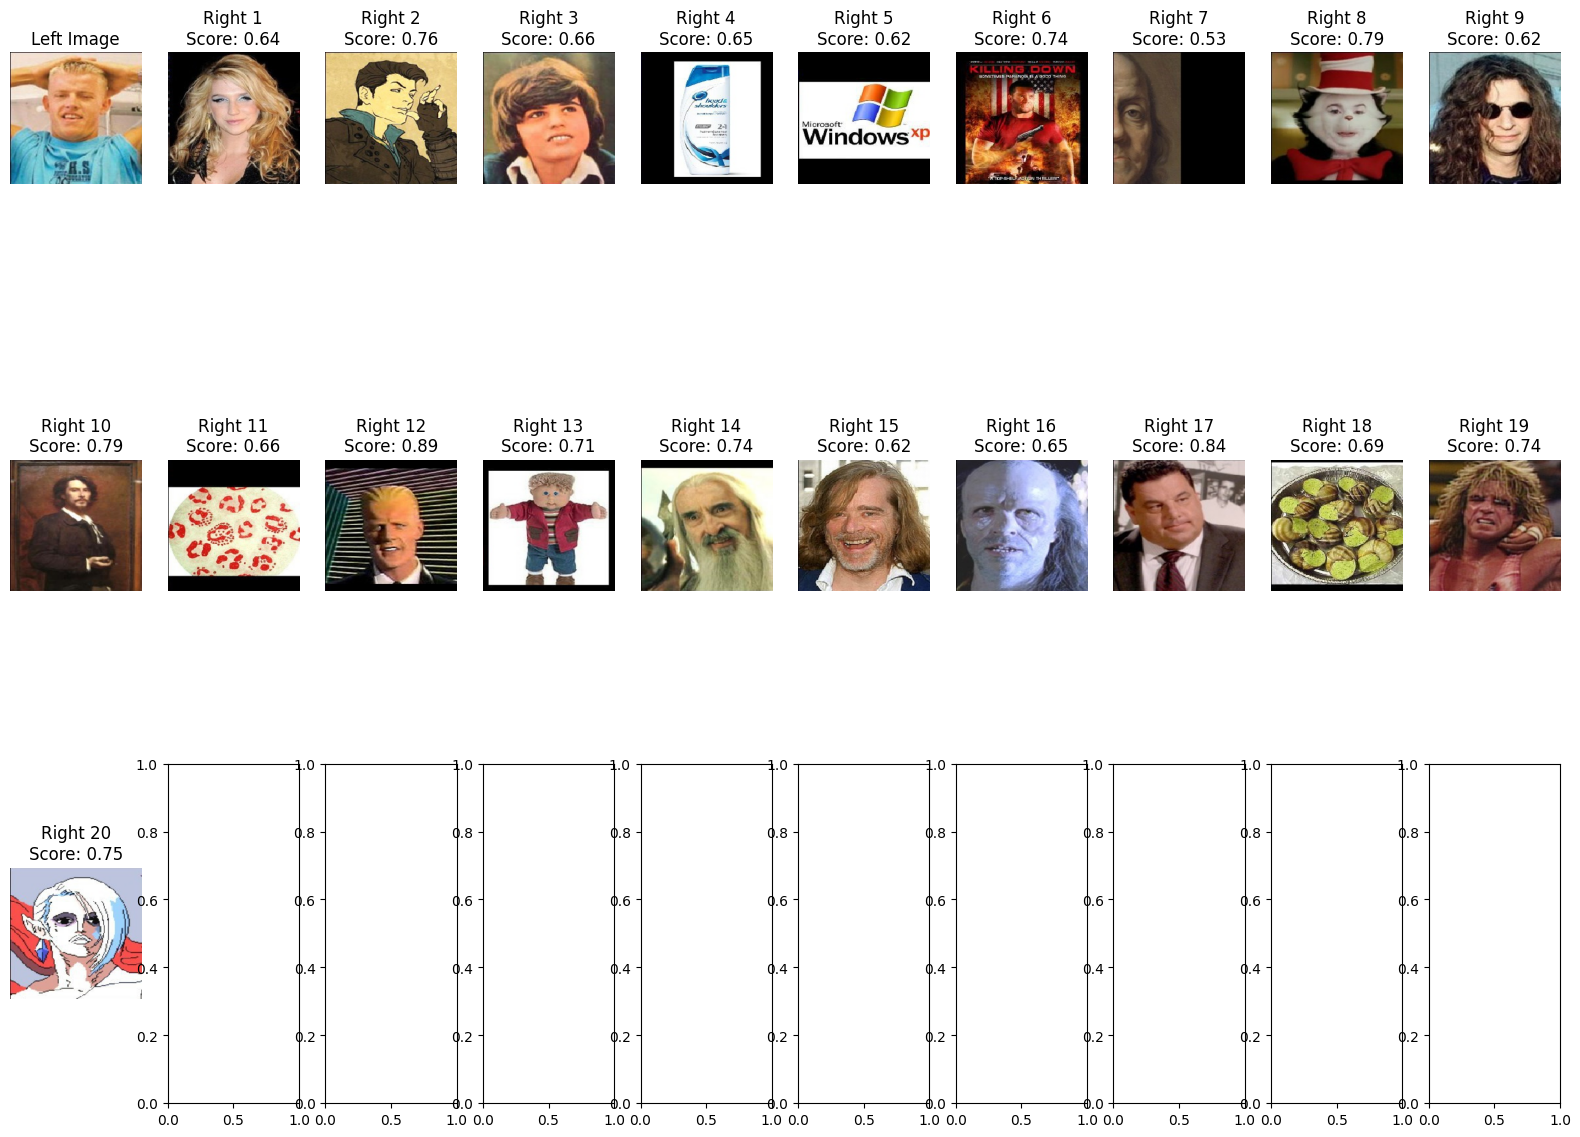

Row 1
  Column left: aci
  Column c0: jzn
  Column c1: hxw
  Column c2: iaj
  Column c3: edq
  Column c4: huu
  Column c5: huk
  Column c6: owo
  Column c7: ntd
  Column c8: uhk
  Column c9: ojv
  Column c10: mhg
  Column c11: exb
  Column c12: pny
  Column c13: kbo
  Column c14: tdb
  Column c15: sok
  Column c16: zsq
  Column c17: yfg
  Column c18: iqx
  Column c19: jnj
Similarity Scores: [0.79118896 0.7812116  0.8955364  0.60611904 0.81940943 0.7606009
 0.65239954 0.74275553 0.7258363  0.7283261  0.7901194  0.7773903
 0.61065745 0.83463764 0.653639   0.8040236  0.7735249  0.67621386
 0.80188626 0.70560473]


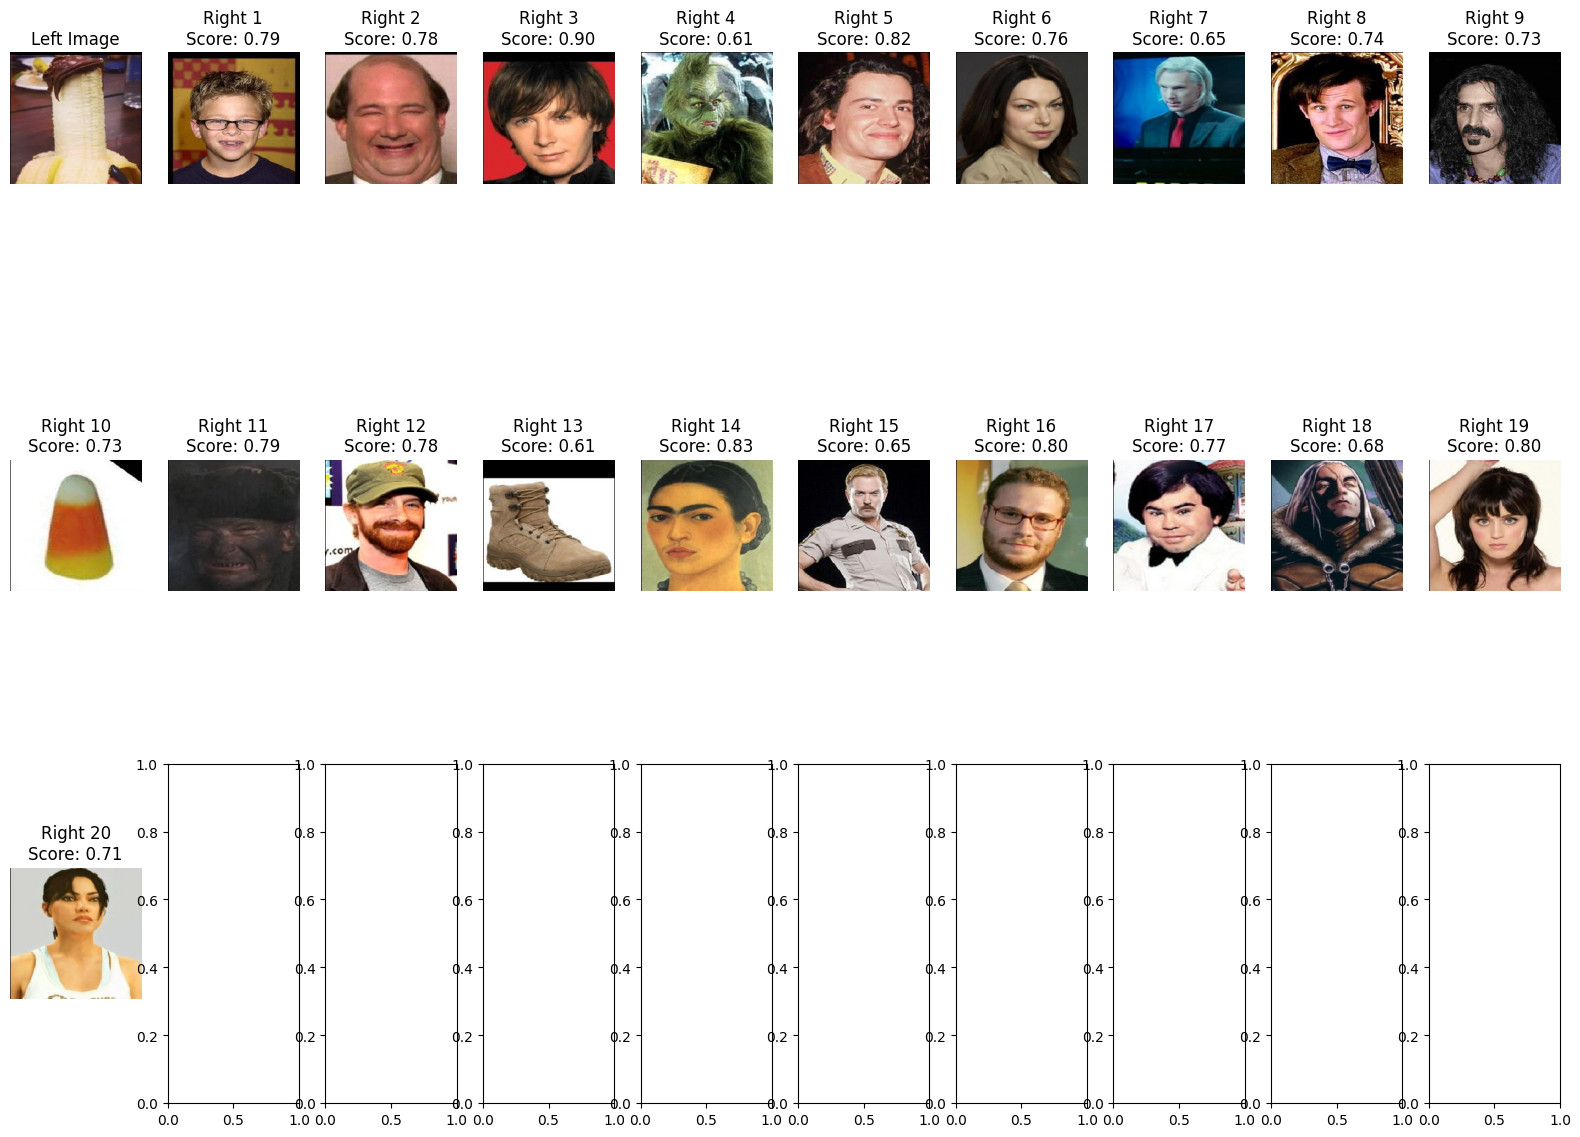

Row 2
  Column left: acn
  Column c0: ksm
  Column c1: tyj
  Column c2: hhy
  Column c3: rph
  Column c4: axt
  Column c5: dby
  Column c6: xiv
  Column c7: aoc
  Column c8: oxb
  Column c9: iyw
  Column c10: vsu
  Column c11: wrx
  Column c12: zem
  Column c13: rkq
  Column c14: vjq
  Column c15: duq
  Column c16: ncp
  Column c17: mst
  Column c18: wzd
  Column c19: gup
Similarity Scores: [0.6933394  0.8493355  0.5899411  0.829006   0.74072945 0.8564975
 0.78936493 0.8140373  0.59118927 0.8317191  0.8549353  0.6552707
 0.8413733  0.5699661  0.6945018  0.73424083 0.82734185 0.82200074
 0.74192965 0.869216  ]


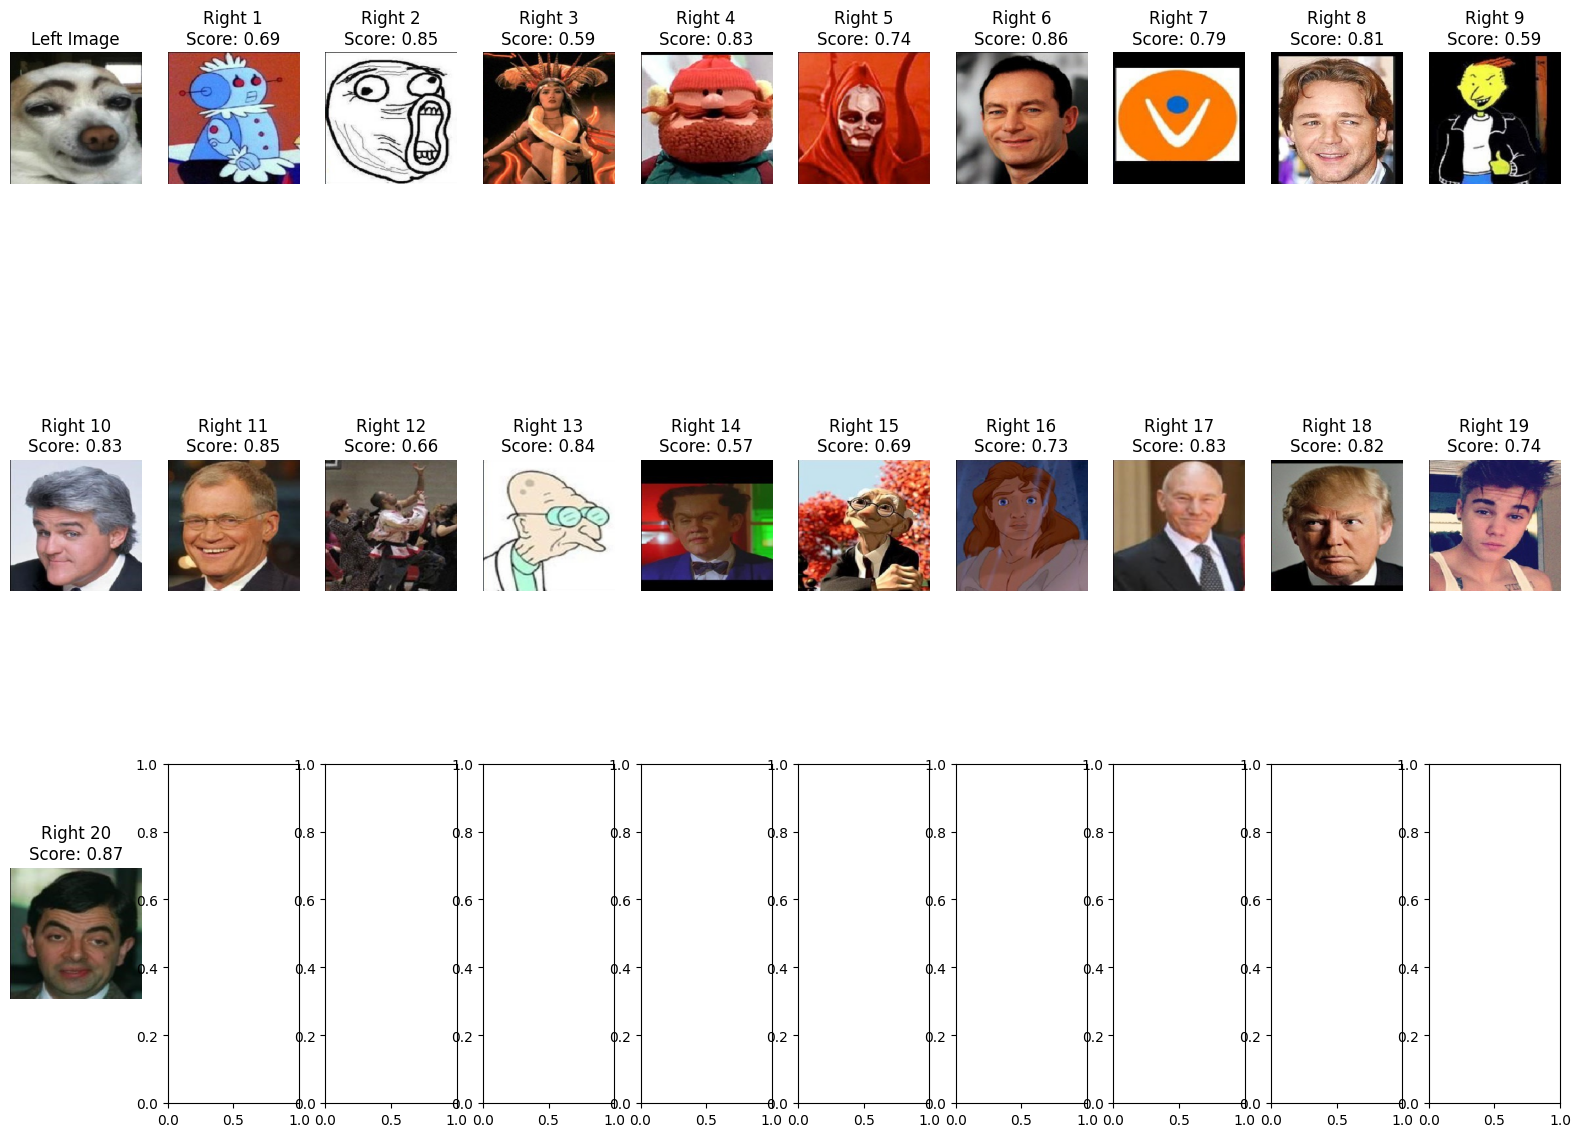

Row 3
  Column left: aco
  Column c0: tft
  Column c1: bxn
  Column c2: vkl
  Column c3: mdq
  Column c4: iqb
  Column c5: uev
  Column c6: mjn
  Column c7: ccy
  Column c8: nje
  Column c9: jsj
  Column c10: flo
  Column c11: ltz
  Column c12: sjz
  Column c13: ind
  Column c14: fbw
  Column c15: ahy
  Column c16: vwe
  Column c17: cog
  Column c18: xcj
  Column c19: boz
Similarity Scores: [0.7426539  0.8465082  0.81964827 0.8333272  0.82451797 0.9531157
 0.7324226  0.87711954 0.8743243  0.58074033 0.79938686 0.8255086
 0.81850445 0.80006933 0.75982976 0.6930555  0.8685228  0.8134214
 0.63528603 0.896713  ]


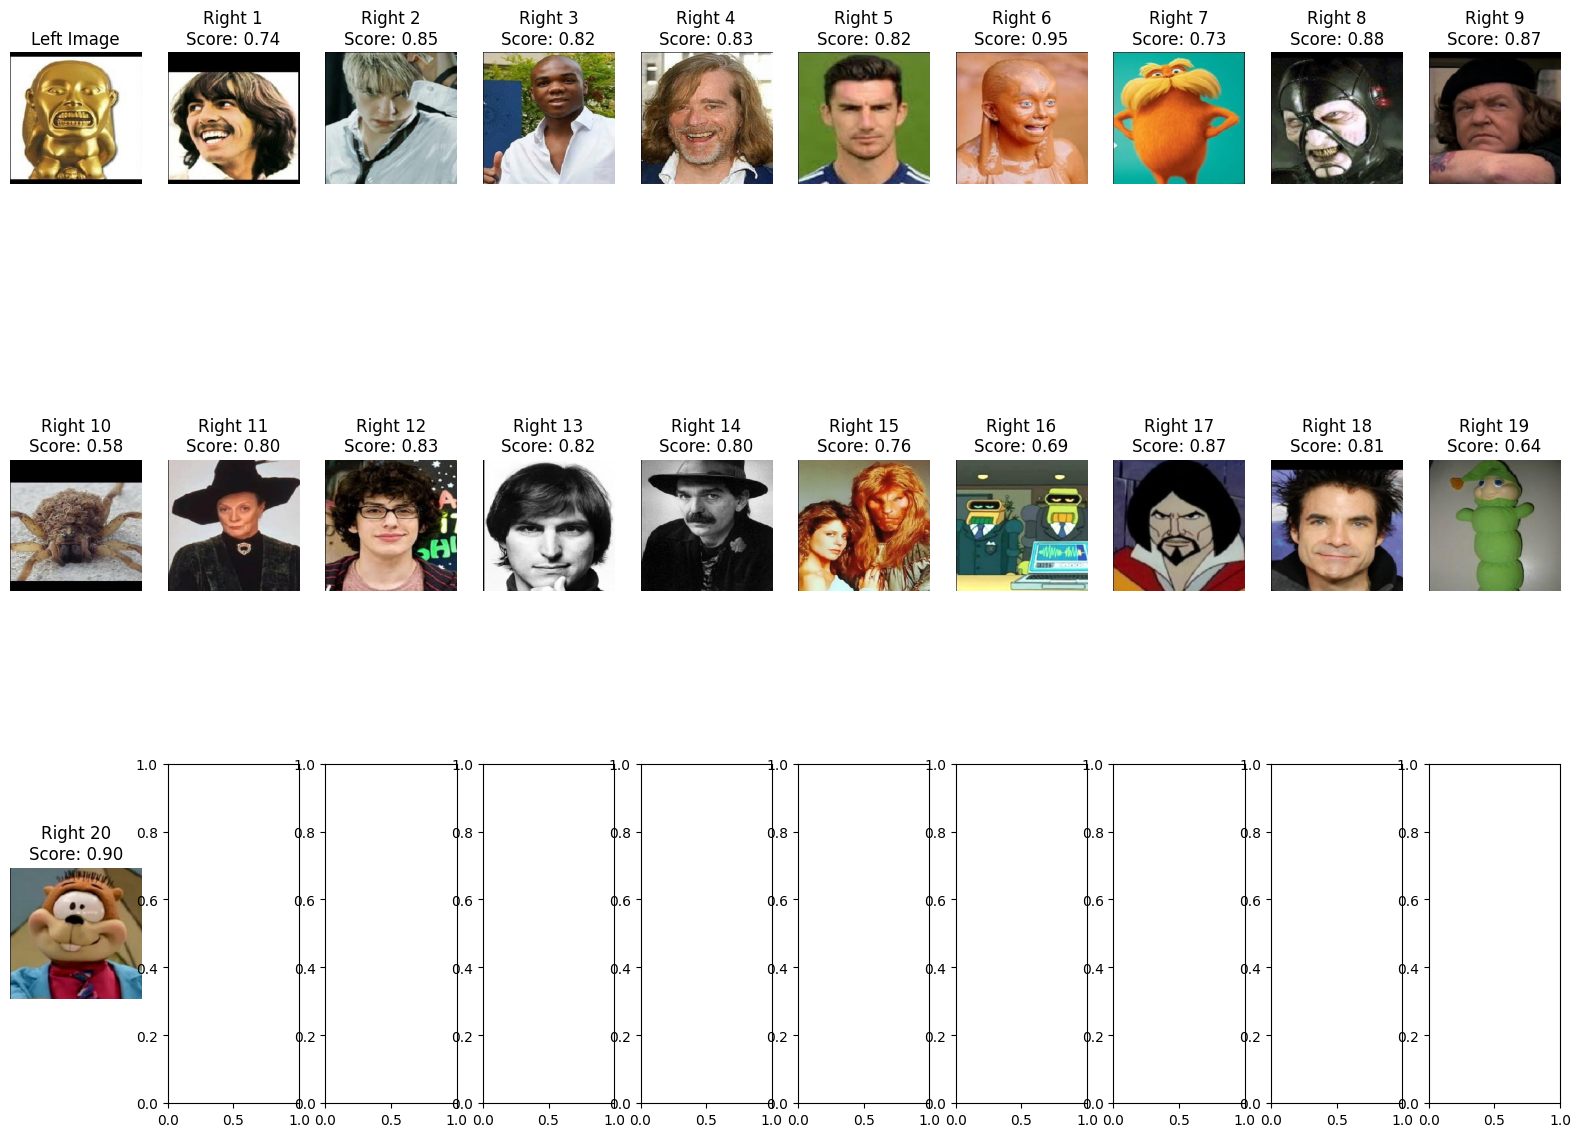

Row 4
  Column left: acu
  Column c0: apn
  Column c1: zip
  Column c2: cxx
  Column c3: cwh
  Column c4: wbu
  Column c5: azy
  Column c6: qoe
  Column c7: wnd
  Column c8: xoo
  Column c9: oxh
  Column c10: zwq
  Column c11: rqi
  Column c12: rei
  Column c13: poj
  Column c14: gos
  Column c15: hif
  Column c16: ami
  Column c17: fhc
  Column c18: ift
  Column c19: xcj
Similarity Scores: [0.84831625 0.77937245 0.8445487  0.7772872  0.83236325 0.8286685
 0.69521713 0.6876108  0.7090827  0.84075093 0.8671141  0.7161598
 0.8605604  0.7531066  0.80213374 0.7625308  0.7476964  0.74445426
 0.7316339  0.5919357 ]


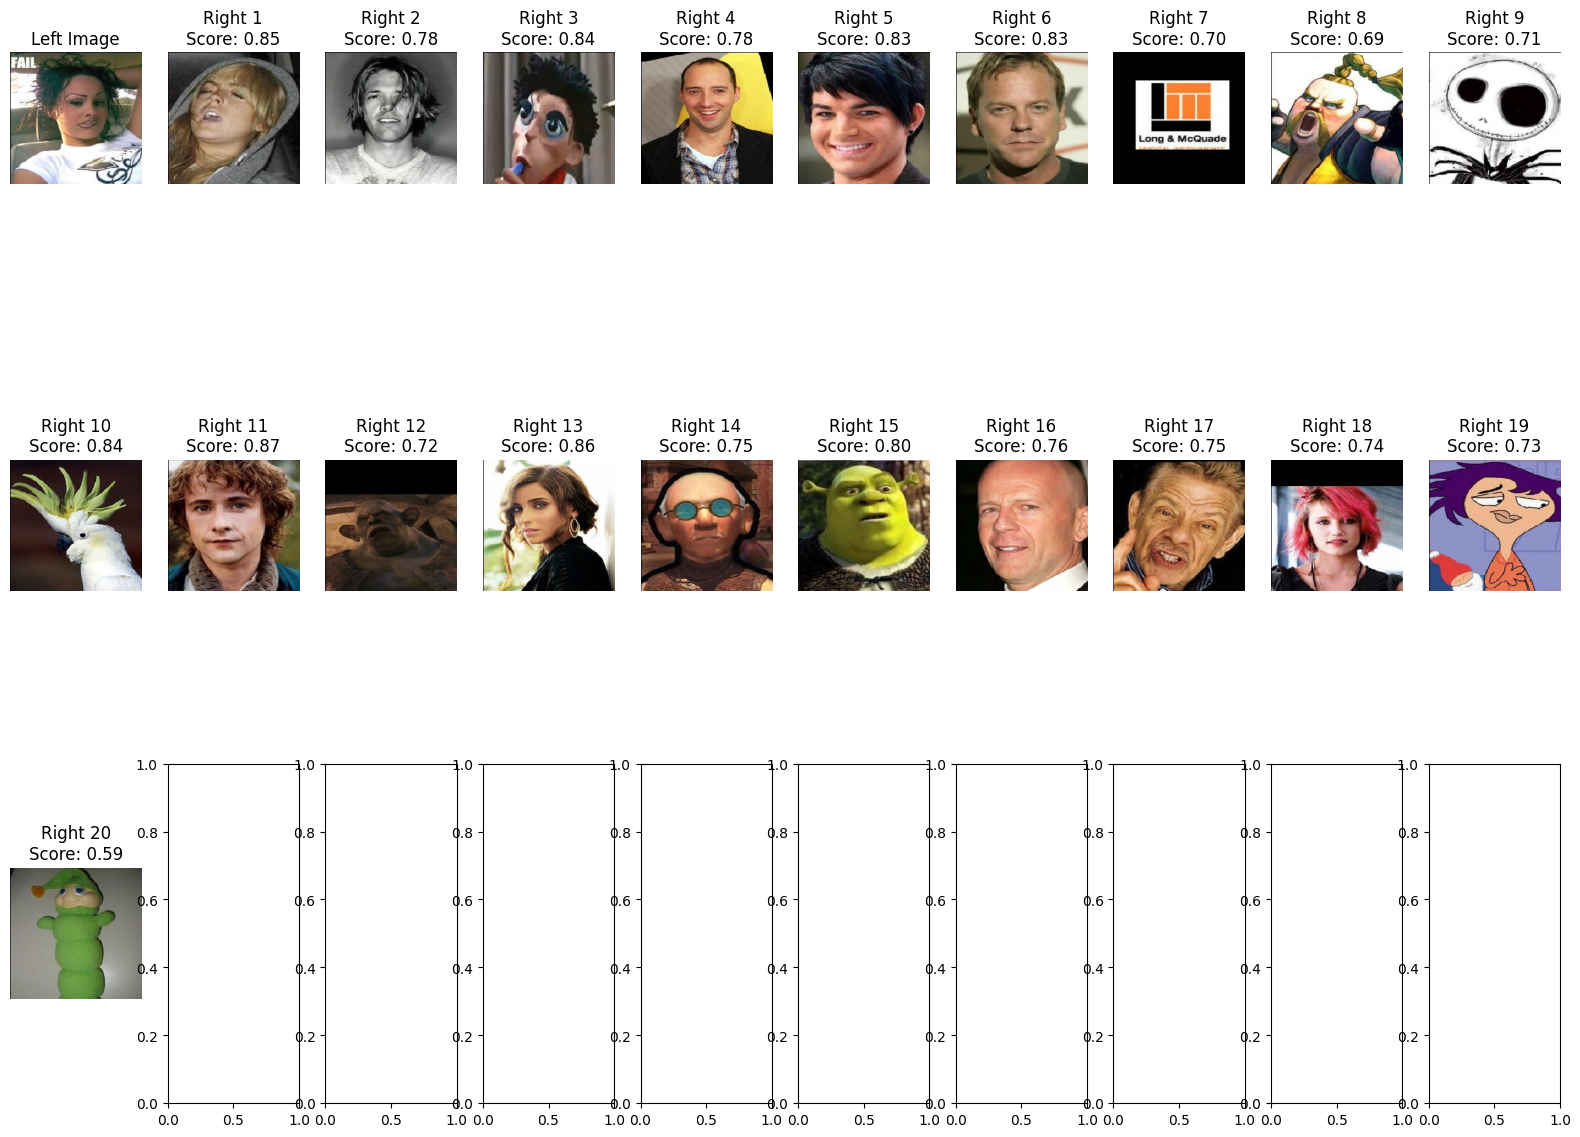

In [41]:
show_test_case(siamese_model, test_candidates_df, row_number=5)

In [44]:
# output_df = pd.DataFrame(columns=["left", "c0", "c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8", "c9", "c10", "c11", "c12", "c13", "c14", "c15", "c16", "c17", "c18", "c19"])
# print(get_test_result(siamese_model, test_candidates_df,output_df, "ResNet50_result.csv"))